In [1]:
from analysis_tools.read_traj import ReadTraj
from analysis_tools.feature_creation import FrameToFeaturesPosition, TrajectoryToFeaturesPosition
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from analysis_tools.radial_distribution_function import RDF, PositionalSuceptibility
from analysis_tools.reservoir_sampler import ReservoirSampler
from analysis_tools.defect_analysis import DefectStats
from analysis_tools.pop2d import POP2D
import gc
from IPython.display import clear_output
import h5py

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
def DownSampleFrames(frames, frame_samples):
    return frames[0::max(len(frames)/frame_samples, 1)][0:frame_samples]

## Specify the conditions

In [5]:
from numpy import arange, array

In [8]:
#VERSION FOR PAPER I
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 10 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 1 

In [9]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p', 400), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer', 400)]

In [10]:
#actual data
etas = []
[etas.extend(etas_) for etas_, _, _ in file_data]
etas = array(etas)
color_ids = []
[color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(file_data)), file_data)]
color_ids = array(color_ids)

## Read in the data

In [11]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

In [12]:
corrected_features = []
incpca_ig = IncrementalPCA(n_components=None, whiten=True) 
force_randomize = False

#loop over data sets 
for phase in ['fit_whitener', 'correct_features']:
    raw_features = []
    
    for etas_, file_base, frame_samples in file_data:

        for eta in etas_:
            print 'COMPUTATION DETAILS'
            print 'file_base = {}'.format(file_base)
            print 'eta = {}'.format(eta)

            #read in data and randomize positions if performing ideal gas correction
            filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
            randomize = (phase == 'fit_whitener') or force_randomize
            frames = ReadTraj(filename, traj_type, shuffle_data, randomize, remove_types)

            #control the number of total frames to analyze
            len_frames_init = len(frames)
            frames = DownSampleFrames(frames, frame_samples)
            print 'using {} frames of {} total'.format(len(frames), len_frames_init)
            
            raw_features.extend(TrajectoryToFeaturesPosition(frames, 
                                                             N_nn=N_nn,  
                                                             nn_inc=nn_inc,
                                                             N_batch=N_batch, 
                                                             batches_per_frame=batches_per_frame))
    if phase == 'fit_whitener':
        print 'Fitting the whitener\n'
        incpca_ig.fit(raw_features)
    else:
        print 'Correcting features\n'
        corrected_features = incpca_ig.transform(raw_features)
            
            

COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.55
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.555
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.56
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.565
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.57
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.575
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.58
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.585
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.59
using 400 frames of 1000 total
COMPUTATION DETAILS
file

using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.645
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.65
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.655
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.66
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.665
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.67
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.675
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.68
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.685
using 400 frames of 100

# Autoencoding

In [13]:
from analysis_tools.autoencoder import AutoEncoder
from sklearn.model_selection import train_test_split

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
dim = corrected_features.shape[1]
print "Dimensionality: {}".format(dim)

Dimensionality: 320


### Train and test sets

In [15]:
corrected_features_train, corrected_features_test = train_test_split(corrected_features, test_size=0.25, random_state=42)

### Build and train the model

In [83]:
from keras.callbacks import ModelCheckpoint

In [84]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.65,
                    activation='selu', kernel_initializer='lecun_normal')

In [85]:
print model.layer_dims

[400, 260, 169, 109, 70, 45, 29, 18, 11, 7, 4, 2, 1, 2, 4, 7, 11, 18, 29, 45, 70, 109, 169, 260, 400, 320]


In [86]:
print model.layer_dims

[400, 260, 169, 109, 70, 45, 29, 18, 11, 7, 4, 2, 1, 2, 4, 7, 11, 18, 29, 45, 70, 109, 169, 260, 400, 320]


In [95]:
model.Compile(optimizer='adamax', loss='mean_squared_error')

In [96]:
checkpointer = ModelCheckpoint(filepath='./model/weights_elu_adam.hdf5', verbose=1, save_best_only=True)

In [103]:
history_raw = model.Fit(corrected_features_train, corrected_features_test,
                epochs=400, batch_size=600, shuffle=True, callbacks=[checkpointer])

Train on 16500 samples, validate on 5500 samples
Epoch 1/400
16500/16500 [==============================] - 4s - loss: 0.8027 - val_loss: 0.8089
Epoch 2/400
16500/16500 [==============================] - 4s - loss: 0.8029 - val_loss: 0.8087
Epoch 3/400
16500/16500 [==============================] - 4s - loss: 0.8037 - val_loss: 0.8089
Epoch 4/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8087
Epoch 5/400
16500/16500 [==============================] - 4s - loss: 0.8030 - val_loss: 0.8087
Epoch 6/400
16500/16500 [==============================] - 4s - loss: 0.8034 - val_loss: 0.8087
Epoch 7/400
16500/16500 [==============================] - 4s - loss: 0.8042 - val_loss: 0.8091
Epoch 8/400
16500/16500 [==============================] - 4s - loss: 0.8039 - val_loss: 0.8088
Epoch 9/400
16500/16500 [==============================] - 4s - loss: 0.8032 - val_loss: 0.8084
Epoch 10/400
16500/16500 [==============================] - 4s - loss: 0.8029 - val_los

16500/16500 [==============================] - 4s - loss: 0.8050 - val_loss: 0.8084
Epoch 41/400
16500/16500 [==============================] - 4s - loss: 0.8053 - val_loss: 0.8092
Epoch 42/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8085
Epoch 43/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8087
Epoch 44/400
16500/16500 [==============================] - 4s - loss: 0.8043 - val_loss: 0.8086
Epoch 45/400
16500/16500 [==============================] - 5s - loss: 0.8055 - val_loss: 0.8086
Epoch 46/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8087
Epoch 47/400
16500/16500 [==============================] - 4s - loss: 0.8052 - val_loss: 0.8086
Epoch 48/400
16500/16500 [==============================] - 4s - loss: 0.8041 - val_loss: 0.8076
Epoch 49/400
16500/16500 [==============================] - 4s - loss: 0.8036 - val_loss: 0.8085
Epoch 50/400
16500/16500 [=================

16500/16500 [==============================] - 4s - loss: 0.8055 - val_loss: 0.8092
Epoch 81/400
16500/16500 [==============================] - 4s - loss: 0.8049 - val_loss: 0.8093
Epoch 82/400
16500/16500 [==============================] - 4s - loss: 0.8049 - val_loss: 0.8094
Epoch 83/400
16500/16500 [==============================] - 4s - loss: 0.8049 - val_loss: 0.8085
Epoch 84/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8087
Epoch 85/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8091
Epoch 86/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8091
Epoch 87/400
16500/16500 [==============================] - 4s - loss: 0.8053 - val_loss: 0.8097
Epoch 88/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8081
Epoch 89/400
16500/16500 [==============================] - 4s - loss: 0.8044 - val_loss: 0.8082
Epoch 90/400
16500/16500 [=================

16500/16500 [==============================] - 4s - loss: 0.8039 - val_loss: 0.8081
Epoch 121/400
16500/16500 [==============================] - 4s - loss: 0.8038 - val_loss: 0.8079
Epoch 122/400
16500/16500 [==============================] - 4s - loss: 0.8033 - val_loss: 0.8082
Epoch 123/400
16500/16500 [==============================] - 4s - loss: 0.8039 - val_loss: 0.8088
Epoch 124/400
16500/16500 [==============================] - 4s - loss: 0.8035 - val_loss: 0.8076
Epoch 125/400
16500/16500 [==============================] - 4s - loss: 0.8034 - val_loss: 0.8085
Epoch 126/400
16500/16500 [==============================] - 4s - loss: 0.8042 - val_loss: 0.8085
Epoch 127/400
16500/16500 [==============================] - 4s - loss: 0.8044 - val_loss: 0.8085
Epoch 128/400
16500/16500 [==============================] - 4s - loss: 0.8043 - val_loss: 0.8084
Epoch 129/400
16500/16500 [==============================] - 4s - loss: 0.8041 - val_loss: 0.8084
Epoch 130/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8072 - val_loss: 0.8097
Epoch 161/400
16500/16500 [==============================] - 4s - loss: 0.8063 - val_loss: 0.8095
Epoch 162/400
16500/16500 [==============================] - 4s - loss: 0.8059 - val_loss: 0.8091
Epoch 163/400
16500/16500 [==============================] - 4s - loss: 0.8055 - val_loss: 0.8093
Epoch 164/400
16500/16500 [==============================] - 4s - loss: 0.8061 - val_loss: 0.8097
Epoch 165/400
16500/16500 [==============================] - 4s - loss: 0.8058 - val_loss: 0.8110
Epoch 166/400
16500/16500 [==============================] - 4s - loss: 0.8059 - val_loss: 0.8094
Epoch 167/400
16500/16500 [==============================] - 4s - loss: 0.8050 - val_loss: 0.8088
Epoch 168/400
16500/16500 [==============================] - 4s - loss: 0.8047 - val_loss: 0.8088
Epoch 169/400
16500/16500 [==============================] - 4s - loss: 0.8047 - val_loss: 0.8085
Epoch 170/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8034 - val_loss: 0.8082
Epoch 201/400
16500/16500 [==============================] - 4s - loss: 0.8035 - val_loss: 0.8080
Epoch 202/400
16500/16500 [==============================] - 4s - loss: 0.8037 - val_loss: 0.8085
Epoch 203/400
16500/16500 [==============================] - 4s - loss: 0.8047 - val_loss: 0.8091
Epoch 204/400
16500/16500 [==============================] - 4s - loss: 0.8053 - val_loss: 0.8093
Epoch 205/400
16500/16500 [==============================] - 4s - loss: 0.8052 - val_loss: 0.8090
Epoch 206/400
16500/16500 [==============================] - 4s - loss: 0.8062 - val_loss: 0.8105
Epoch 207/400
16500/16500 [==============================] - 4s - loss: 0.8062 - val_loss: 0.8100
Epoch 208/400
16500/16500 [==============================] - 4s - loss: 0.8063 - val_loss: 0.8100
Epoch 209/400
16500/16500 [==============================] - 4s - loss: 0.8061 - val_loss: 0.8099
Epoch 210/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8053 - val_loss: 0.8100
Epoch 240/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8083
Epoch 241/400
16500/16500 [==============================] - 4s - loss: 0.8042 - val_loss: 0.8081
Epoch 242/400
16500/16500 [==============================] - 4s - loss: 0.8046 - val_loss: 0.8087
Epoch 243/400
16500/16500 [==============================] - 4s - loss: 0.8044 - val_loss: 0.8086
Epoch 244/400
16500/16500 [==============================] - 4s - loss: 0.8043 - val_loss: 0.8083
Epoch 245/400
16500/16500 [==============================] - 4s - loss: 0.8039 - val_loss: 0.8092
Epoch 246/400
16500/16500 [==============================] - 4s - loss: 0.8047 - val_loss: 0.8092
Epoch 247/400
16500/16500 [==============================] - 4s - loss: 0.8049 - val_loss: 0.8084
Epoch 248/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8087
Epoch 249/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8036 - val_loss: 0.8077
Epoch 280/400
16500/16500 [==============================] - 4s - loss: 0.8032 - val_loss: 0.8087
Epoch 281/400
16500/16500 [==============================] - 4s - loss: 0.8040 - val_loss: 0.8084
Epoch 282/400
16500/16500 [==============================] - 4s - loss: 0.8037 - val_loss: 0.8083
Epoch 283/400
16500/16500 [==============================] - 4s - loss: 0.8040 - val_loss: 0.8086
Epoch 284/400
16500/16500 [==============================] - 4s - loss: 0.8039 - val_loss: 0.8086
Epoch 285/400
16500/16500 [==============================] - 4s - loss: 0.8036 - val_loss: 0.8075
Epoch 286/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8075
Epoch 287/400
16500/16500 [==============================] - 4s - loss: 0.8028 - val_loss: 0.8073
Epoch 288/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8075
Epoch 289/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8043 - val_loss: 0.8080
Epoch 320/400
16500/16500 [==============================] - 4s - loss: 0.8034 - val_loss: 0.8079
Epoch 321/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8076
Epoch 322/400
16500/16500 [==============================] - 4s - loss: 0.8027 - val_loss: 0.8079
Epoch 323/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8079
Epoch 324/400
16500/16500 [==============================] - 4s - loss: 0.8035 - val_loss: 0.8075
Epoch 325/400
16500/16500 [==============================] - 4s - loss: 0.8033 - val_loss: 0.8073
Epoch 326/400
16500/16500 [==============================] - 4s - loss: 0.8030 - val_loss: 0.8082
Epoch 327/400
16500/16500 [==============================] - 4s - loss: 0.8033 - val_loss: 0.8073
Epoch 328/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8077
Epoch 329/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8037 - val_loss: 0.8083
Epoch 360/400
16500/16500 [==============================] - 4s - loss: 0.8032 - val_loss: 0.8079
Epoch 361/400
16500/16500 [==============================] - 4s - loss: 0.8031 - val_loss: 0.8082
Epoch 362/400
16500/16500 [==============================] - 4s - loss: 0.8036 - val_loss: 0.8086
Epoch 363/400
16500/16500 [==============================] - 4s - loss: 0.8035 - val_loss: 0.8084
Epoch 364/400
16500/16500 [==============================] - 4s - loss: 0.8045 - val_loss: 0.8088
Epoch 365/400
16500/16500 [==============================] - 4s - loss: 0.8043 - val_loss: 0.8091
Epoch 366/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8101
Epoch 367/400
16500/16500 [==============================] - 4s - loss: 0.8048 - val_loss: 0.8084
Epoch 368/400
16500/16500 [==============================] - 4s - loss: 0.8036 - val_loss: 0.8077
Epoch 369/400
16500/16500 [=======

16500/16500 [==============================] - 4s - loss: 0.8065 - val_loss: 0.8122
Epoch 400/400
16500/16500 [==============================] - 4s - loss: 0.8093 - val_loss: 0.8138


### Check out the results 

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline 

In [48]:
#selu_results = deepcopy(history_raw.history['val_loss'])

In [82]:
non_linear_results_5 = deepcopy(history_raw.history['val_loss'])

(0.8, 0.86)

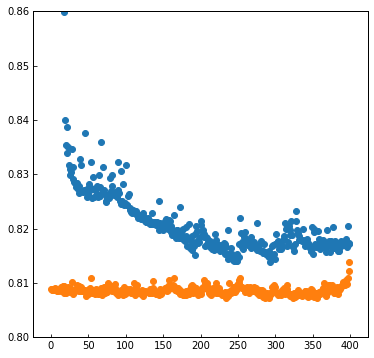

In [104]:
#plt.scatter(range(len(linear_results)), linear_results)
#plt.scatter(range(len(non_linear_results)), non_linear_results)
#plt.scatter(range(len(non_linear_results_2)), non_linear_results_2)
plt.scatter(range(len(selu_results)), selu_results)
plt.scatter(range(len(history_raw.history['val_loss'])), history_raw.history['val_loss'])
plt.ylim(0.8,0.86)

In [109]:
model.Summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 320)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 400)               128400    
_________________________________________________________________
dense_318 (Dense)            (None, 260)               104260    
_________________________________________________________________
dense_319 (Dense)            (None, 169)               44109     
_________________________________________________________________
dense_320 (Dense)            (None, 109)               18530     
_________________________________________________________________
dense_321 (Dense)            (None, 70)                7700      
_________________________________________________________________
dense_322 (Dense)            (None, 45)                3195      
__________

In [105]:
encoded_data = model.Predict(corrected_features)

In [106]:
from numpy import mean

In [107]:
OP = []
for i in range(len(etas)):
    OP.append(mean(encoded_data[:,0][i*400:i*400+400]))

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


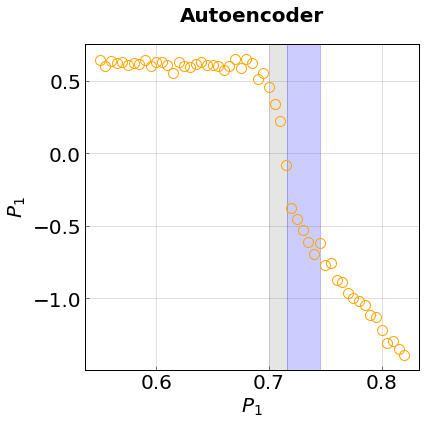

In [108]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


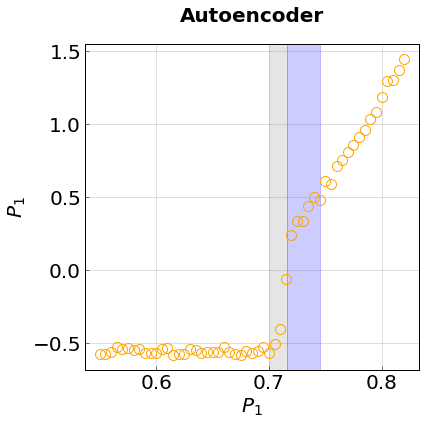

In [47]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

In [ ]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(encoded_data[:,0][:skip], encoded_data[:,1][:skip], marker='o', linewidth=0.0, markersize=8, color = 'orange', alpha=0.1) #markerfacecolor='None')   
plt.plot(encoded_data[:,0][skip:], encoded_data[:,1][skip:], marker='o', linewidth=0.0, markersize=8, color = 'purple', alpha=0.1, markerfacecolor='None')  
#plt.plot(encoded_data[:,0][:skip], encoded_data[:,1][:skip], marker='o', linewidth=0.0, markersize=4, color = 'orange', alpha=0.1) #markerfacecolor='None')   

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(-1.2,20)
#plt.ylim(-1.2,20)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

In [121]:
model.autoencoder.history?